In [44]:
import numpy as np
import matplotlib.pyplot as plt  # Plotting library
np.random.seed(seed=1)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets, cross_validation, metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections
import time

In [45]:
# load the data from scikit-learn.
digits = datasets.load_digits()
#dataset = datasets.fetch_mldata("MNIST Original")

# Load the targets.
# Note that the targets are stored as digits, these need to be 
#  converted to one-hot-encoding for the output sofmax layer.
T = np.zeros((digits.target.shape[0],10))
T[np.arange(len(T)), digits.target] += 1

# Divide the data into a train and test set.
X_train, X_test, T_train, T_test = cross_validation.train_test_split(
   digits.data, T, test_size=0.1)
#(X_train, X_test, T_train, T_test) = cross_validation.train_test_split(
#	dataset.data / 255.0, dataset.target.astype("int0"), test_size = 0.33)
# Divide the test set into a validation set and final test set.
X_validation, X_test, T_validation, T_test = cross_validation.train_test_split(
    X_test, T_test, test_size=0.5)
print(X_train.shape)
print(T_train.shape)
print(X_train[0,:])
print(T_train[0,:])

(1617, 64)
(1617, 10)
[ 0.  0.  2. 13. 16. 16.  7.  0.  0.  0. 12. 15. 12. 16. 10.  0.  0.  0.
 16.  9.  0. 14.  6.  0.  0.  0.  3.  0.  4. 16.  1.  0.  0.  0.  0. 10.
 14. 16.  6.  0.  0.  0.  3. 16. 16. 11.  2.  0.  0.  0.  0.  9. 14.  0.
  0.  0.  0.  0.  2. 15.  6.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


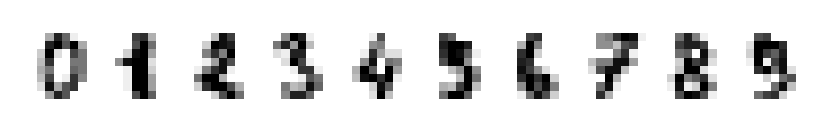

In [46]:
# Plot an example of each image.
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[i], cmap='binary') 
    ax.axis('off')
plt.show()

In [47]:
def tanh(x):
    return np.tanh(x)

In [48]:
#test tanh
print(tanh(np.array([[1,2,3],[3,4,5]])))

[[0.76159416 0.96402758 0.99505475]
 [0.99505475 0.9993293  0.9999092 ]]


In [49]:
def softmax(y):
    #y1= np.exp(y)/ np.sum(np.exp(y), axis = 1, keepdims=True)
    y1= y/ np.sum(y, axis = 1, keepdims=True)
    idx = y1.argmax(axis=1)
    y1 = (idx[:,None] == np.arange(y1.shape[1])).astype(float)
    return y1

In [50]:
#test softmax
x = np.array([[.1,6,6],[4,10,10]])
print(softmax(x))

[[0. 1. 0.]
 [0. 1. 0.]]


In [51]:
def sigmoid(x) :
    return (1/1+np.exp(-x))

In [52]:
def relu(x):
    return np.where(x<0, 0, x)

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
def logit(y, minThreshold=0.0001, maxThreshold=9999):
    
    np.where( y < minThreshold , minThreshold, y)
    np.where( y > maxThreshold ,maxThreshold, y)
    
    z = -np.log((1-y)/y)
    return z
        
    

In [55]:
def normalize(data):
    nData = data/np.linalg.norm(data)
    max = np.max(data, axis=1, keepdims=True)
    min = np.min(data, axis = 1 , keepdims=True)
    nData = (data-min)/(max-min)
    return nData

In [56]:
#test normalize
normalize(np.array([[1,2,3],[2,4,6]]))

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [57]:
def mappedToSize(inputs, newSize):
    outputs = np.zeros((inputs.shape[0], newSize) )
    m = inputs.shape[1]
    n= newSize
    w = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            outputs[:,i] += (n -np.abs(i-j)-1)*inputs[:,j]*2/(m*(2*n -m-1)) 
            w[i,j]=(n -np.abs(i-j)-1)
    w=normalize(w.T)
    #outputs = np.dot( inputs, w)
    return (outputs)
        
        

In [58]:
#test expandToSize function
mappedToSize(np.array([[1,2,3],[2,4,6]]), 6)

array([[1.83333333, 2.16666667, 2.16666667, 1.66666667, 1.16666667,
        0.66666667],
       [3.66666667, 4.33333333, 4.33333333, 3.33333333, 2.33333333,
        1.33333333]])

In [59]:
def train(X, Y, layout, activations):
    xi = X
    W=[]
    B=[]
    for i in range(len(layout)):
        if i < len(layout)-1  :
            yi = mappedToSize(Y, layout[i]) 
        else:
            yi = Y
        xf = xi    
        wi = (np.dot(np.linalg.pinv((xi)), yi))
        bi = np.mean(activations[i](np.dot((xi), wi)) -yi, axis=0)
        
        if i < len(layout)-1:
            xi =activations[i]((np.dot((xi), wi)+bi))
        else :
            xi =softmax(np.dot((xi), wi)+bi)
         
        W.append(wi)
        B.append(bi)
    return W, B

In [60]:
def train_batch(X, Y, layout, activations):
    xi = X
    W=[]
    B=[]
    min_batch_size =  np.floor(X.shape[0]/len(layout)).astype(int)
    for i in range(len(layout)):
        if min_batch_size*(i +1) < X.shape[0] :
            xi =X[min_batch_size*i: min_batch_size*(i+1), :] 
        else:
            xi= X[min_batch_size*i: , :] 
            
        if i < len(layout)-1  :
            yi = expandToSize(Y, layout[i])
        else:
            yi = Y
        xi = X   
        for j in range(i):
            wj=W[j]
            bj= B[j]
            xi =np.dot(activations[i](xi), wj)+bj            
       
        wi = np.dot(np.linalg.pinv(activations[i](xi)), yi)
        bi = np.mean(np.dot(activations[i](xi), wi) -yi, axis=0)
        
        if i < len(layout)-1:
            xi =np.dot(activations[i](xi), wi)+bi
        else :
            xi =softmax(np.dot(activations[i](xi), wi)+bi)
         
        W.append(wi)
        B.append(bi)
    return W, B

In [61]:
#test train
X = normalize(np.array([[1,2,3],[7,8,9],[2,6,9 ],[34,56,23]]))
Y = normalize(np.array([1,2,3,10]).reshape(4,1))
layout = [10,20,40,50]
activations=[sigmoid, sigmoid, sigmoid, sigmoid]
#W, B = train(X, Y, layout, activations)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [62]:
def eval(X, W, B, layout, activations):
    xi = X
    for i in range(len(layout)):
        wi=W[i]
        bi=B[i]
        xf = xi
        if i < len(layout)-1:
            xi =activations[i](np.dot((xi), wi)+bi)
        else :
            xi =softmax(np.dot((xi), wi)+bi)
    return xi
    

In [63]:
#test eval
X = normalize(np.array([[1,2,3],[7,8,9],[2,6,9 ],[34,56,23]]))
Y = normalize(np.array([1,2,3,10]).reshape(4,1))
layout = [10,20,40,50]
activations=[sigmoid, sigmoid, sigmoid, sigmoid]
#W, B = train(X, Y, layout, activations)
#Y1 = eval(X, W, B, layout, activations)
#print( mean_absolute_percentage_error(Y[0],Y1[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [64]:
#layout = [50,40,30,25, 25, 20,15,10,10]
#activations=[sigmoid, sigmoid, sigmoid, sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid]
layout = [100,50,40,10]
activations=[tanh, tanh, tanh, tanh]
start_time = time.time()
W, B = train(X_train, T_train, layout, activations)
print("training time : " + str( time.time() - start_time))
Y_train_predict = eval(X_train, W, B, layout, activations)
# Get results of train data
y_true = np.argmax(T_train, axis=1)  # Get the target outputs
y_pred = np.argmax(Y_train_predict, axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the train set is {:.2f}'.format(test_accuracy))

Y_validation_predict = eval(X_validation, W, B, layout, activations)
# Get results of validation data
y_true = np.argmax(T_validation, axis=1)  # Get the target outputs
y_pred = np.argmax(Y_validation_predict, axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the validation set is {:.2f}'.format(test_accuracy))

Y_test_predict = eval(X_test, W, B, layout, activations)
# Get results of test data
y_true = np.argmax(T_test, axis=1)  # Get the target outputs
y_pred = np.argmax(Y_test_predict, axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))

training time : 0.17676091194152832
The accuracy on the train set is 0.96
The accuracy on the validation set is 0.96
The accuracy on the test set is 0.97


In [65]:
print (confusion_matrix(y_true, y_pred))
print (classification_report(y_true, y_pred))

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  1]
 [ 0  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  1  0  0  0  1  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  7]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.88      1.00      0.93         7
          2       1.00      1.00      1.00        10
          3       1.00      0.88      0.93         8
          4       1.00      1.00      1.00         8
          5       0.89      1.00      0.94         8
          6       1.00      1.00      1.00        13
          7       1.00      1.00      1.00        10
          8       1.00      0.80      0.89        10
          9       0.88      1.00      0.93         7

avg / total       0.97      0.97      0.97        90



C:\Users\admin
